# Import the Necessary Libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score
from keras.layers import concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten,Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers



# Data Collection


In [11]:
!mkdir "/tmp/X-RAY/"

mkdir: cannot create directory ‘/tmp/X-RAY/’: File exists


In [14]:
!mkdir -p tmp/X-RAY/COVID
!mkdir -p tmp/X-RAY/LUNG_OPACITY
!mkdir -p tmp/X-RAY/NORMAL
!mkdir -p tmp/X-RAY/PNEUMONIA

In [15]:
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/*.png tmp/X-RAY/COVID/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/*.png tmp/X-RAY/NORMAL/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png tmp/X-RAY/LUNG_OPACITY/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral\ Pneumonia/images/*.png tmp/X-RAY/PNEUMONIA/


In [16]:
!ls tmp/X-RAY/

COVID  LUNG_OPACITY  NORMAL  PNEUMONIA


# Data Preprocessing

In [17]:
dataset_dir = "tmp/X-RAY/"

categories = ["COVID", "LUNG_OPACITY", "NORMAL", "PNEUMONIA"]
image_counts = {}

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    image_counts[category] = len(os.listdir(category_path))

print(image_counts)


{'COVID': 3616, 'LUNG_OPACITY': 6012, 'NORMAL': 10192, 'PNEUMONIA': 1345}


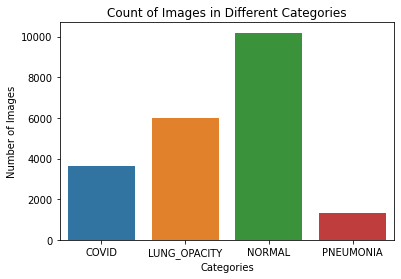

In [18]:
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))

plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Count of Images in Different Categories")
plt.show()

# Data Augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path="tmp/X-RAY/"

In [20]:
train_datagen = ImageDataGenerator(rescale=1/255,zoom_range=0.2,shear_range=0.2,validation_split=0.2)

In [21]:
train=train_datagen.flow_from_directory(train_path,target_size=(299,299),batch_size=16,subset='training',class_mode='categorical')# input pixels of images trained for VGGnet
test=train_datagen.flow_from_directory(train_path,target_size=(299,299),batch_size=16,subset='validation',class_mode='categorical')

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


# Model Definition -Inception 

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
incep= InceptionV3(include_top=False,input_shape=(299,299,3))

87924736/87910968 [==============================] - 0s 0us/step


In [23]:
for layer in incep.layers:
    layer.trainable=False

In [28]:
x = Flatten()(incep.output)
output=Dense(4,activation='softmax')(x)

In [31]:
inc_model=Model(incep.input,output)
inc_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=(['accuracy']))
inc_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
from keras.callbacks import EarlyStopping
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

# Model Training

In [33]:
epochs = 20  
batch_size  = 16
inc_history = inc_model.fit(train,
                              steps_per_epoch = 16933 // batch_size,
                              epochs = 20,
                              validation_data = test,
                              callbacks=[EarlyStopping]) 

Epoch 1/20
1058/1058 [==============================] - 410s 378ms/step - loss: 5.1162 - accuracy: 0.7844 - val_loss: 4.4273 - val_accuracy: 0.8537
Epoch 2/20
1058/1058 [==============================] - 395s 374ms/step - loss: 4.8085 - accuracy: 0.8418 - val_loss: 5.0043 - val_accuracy: 0.8686
Epoch 3/20
1058/1058 [==============================] - 393s 371ms/step - loss: 4.4383 - accuracy: 0.8599 - val_loss: 8.9876 - val_accuracy: 0.7918
Epoch 4/20
1058/1058 [==============================] - 391s 370ms/step - loss: 4.4936 - accuracy: 0.8703 - val_loss: 6.5784 - val_accuracy: 0.8485
Epoch 5/20
1058/1058 [==============================] - 395s 373ms/step - loss: 4.3424 - accuracy: 0.8773 - val_loss: 5.5857 - val_accuracy: 0.8573
Epoch 6/20
1058/1058 [==============================] - 396s 374ms/step - loss: 4.3367 - accuracy: 0.8824 - val_loss: 4.8964 - val_accuracy: 0.8880
Epoch 7/20
1058/1058 [==============================] - 394s 372ms/step - loss: 3.7923 - accuracy: 0.8986 - val_

# Evaluation

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)  
test_generator = test_datagen.flow_from_directory(
    "tmp/X-RAY/",
    target_size=(299,299),   
    batch_size=64,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False,  # Ensure no shuffling for consistent evaluation
    subset='validation'   
)

Found 4232 images belonging to 4 classes.


In [40]:
y_pred = inc_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 88.26%


In [41]:
class_names = ['COVID', 'LUNG_OPACITY','NORMAL', 'PNEUMONIA']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       COVID       0.96      0.74      0.83       723
LUNG_OPACITY       0.83      0.89      0.86      1202
      NORMAL       0.89      0.93      0.91      2038
   PNEUMONIA       0.91      0.86      0.88       269

    accuracy                           0.88      4232
   macro avg       0.90      0.85      0.87      4232
weighted avg       0.89      0.88      0.88      4232



# Evaluation Graphs

In [42]:
training_loss = inc_history.history['loss']
validation_loss = inc_history.history['val_loss']

training_accuracy = inc_history.history['accuracy']
validation_accuracy = inc_history.history['val_accuracy']

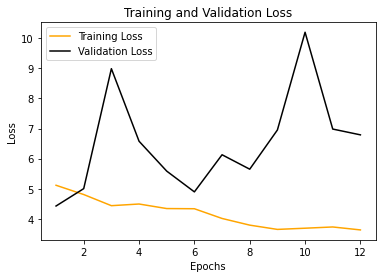

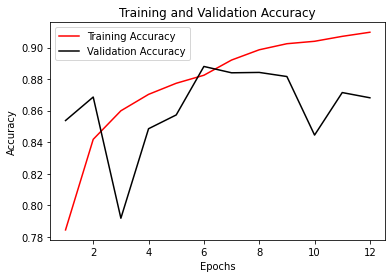

In [43]:
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'orange', label='Training Loss')
plt.plot(epochs, validation_loss, 'k', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'k', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [44]:
import pandas as pd
names=["COVID","LUNG_OPACITY","NORMAL","PNEUMONIA"]
confusion_mat=pd.crosstab(y_true, y_pred_classes)
confusion_mat.columns=names
confusion_mat.index=names
confusion_mat

,COVID,LUNG_OPACITY,NORMAL,PNEUMONIA
COVID,533,109,75,6
LUNG_OPACITY,13,1072,117,0
NORMAL,9,113,1900,16
PNEUMONIA,0,1,38,230
